In [4]:
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
%matplotlib inline

################################################################################
# Some simple plotting utilities
################################################################################


def plot_data(data: np.ndarray,
              labels: np.ndarray,
              ax: matplotlib.axes.Axes = None):
    """
    A helper function to plot our data sets

    PARAMETERS
    ----------
    data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows

    labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
              element. The jth element is the label of the jth example

    ax        An optional matplotlib axis object to plot to
    """

    # require shape (n, 2)
    assert data.ndim == 2
    assert data.shape[-1] == 2

    if type(data) == torch.Tensor:
        data = data.numpy()

    # plot the data
    pos_idx = np.where(labels == 1)
    neg_idx = np.where(labels == -1)

    if ax is None:
        ax = plt
    ax.plot(
        data.T[0, pos_idx],
        data.T[1, pos_idx],
        'r^',
        label='positive'
    )
    ax.plot(
        data.T[0, neg_idx],
        data.T[1, neg_idx],
        'bo',
        label='negative'
    )
    ax.axis('equal')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    if ax is None:
        plt.show()


def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: matplotlib.axes.Axes = None
                          ):
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for class +1 and a region for
    class -1.

    PARAMETERS
    ----------
    model       A callable model that can take 2-d real-valued input and produce
                a +1 or -1 label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be caluclated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis.
    # This will let us draw the decision boundary later
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Predict the class of each point in XGrid, using the classifier.
    # This shows our regions determined by the classifier
    if isinstance(model, nn.Module):
        with torch.no_grad():
            pl = model(torch.tensor(data).to(dtype=torch.float32))
            predicted_labels = np.sign(pl.numpy())
    else:
        predicted_labels = model(data)

    predicted_labels = predicted_labels.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    if ax is None:
        plt.show()


def compute_bounds(features):
    min1, max1 = features[:, 0].min()-1, features[:, 0].max()+1
    min2, max2 = features[:, 1].min()-1, features[:, 1].max()+1
    return (min1, max1, min2, max2)


def plot_decision_regions(
        features, targets, model,
        axis=None, transform=None,
        bounds=None,
        title='Decision Surface'):
    """
    Slightly different plotting approach than above. Used in backprop demo.

    This function produces a single plot containing a scatter plot of the
    features, targets, and decision region of the model.

    Args:
        features (np.ndarray): 2D array containing real-valued inputs.
        targets (np.ndarray): 1D array containing binary targets.
        model: a learner with .predict() method
        axis: the axis on which to plot. If None, create a new plot
        title: title of the plot
    Returns:
        None (plots to the active figure)
    """

    # define bounds of the domain
    if bounds is None:
        min1, max1, min2, max2 = compute_bounds(features)
    else:
        min1, max1, min2, max2 = bounds

    # define grid for visualizing decision regions
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    xx, yy = np.meshgrid(x1grid, x2grid)

    # flatten grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontally stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))

    # if we're transforming the features, do that now
    #     this allows xx and yy to still be in 2D for the visualization
    #     but grid has been transformed so it matches up with the fit model
    if transform is not None:
        grid = transform(grid)

    # generate predictions over grid
    yhat = model(grid)

    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)


    if axis is None:
        fig, axis = plt.subplots()

    # plot the grid of x, y and z values as a surface
    binary_cmap = matplotlib.colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axis.contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)

    # plot "negative" class:
    row_idx_neg = np.where(targets < 0.5)[0]
    axis.scatter(
        features[row_idx_neg, 0], features[row_idx_neg, 1],
        label='negative')

    # plot "positive" class:
    row_idx_pos = np.where(targets > 0.5)[0]
    axis.scatter(
        features[row_idx_pos, 0], features[row_idx_pos, 1],
        label='positive')

    axis.set_title(title)
    axis.set_xlim(min1, max1)
    axis.set_ylim(min2, max2)

    axis.legend(loc="upper left")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Accuracy: 50.00%


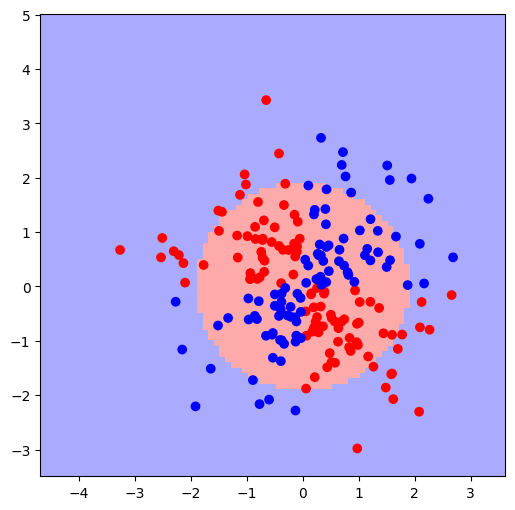

In [121]:
%pip install torch
%pip install matplotlib
%pip install numpy

import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import sys
import os
import random

%matplotlib inline

np.random.seed(42)
torch.manual_seed(0)

def read_data(name,mode):

    x_data = []
    y_data = []
    label_data = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root,name,mode)

    i = 0
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                x_data.append([1.0,x1,x2])
                y_data.append([y])
                temp = [0,0]
                temp[y] = 1
                label_data.append(temp)
            i = i + 1
    xs = np.array(x_data,dtype='float32')
    ys = np.array(y_data,dtype='float32')
    labels = np.array(label_data,dtype='float32')
    return(xs,ys,labels)

class net3(nn.Module):
    def __init__(self,input_size,nodes,output_size):
        super(net3,self).__init__()
        self.l1 = nn.Linear(input_size,nodes)
        self.activation = nn.Sigmoid()

    def forward(self,x):
        output = self.l1(x)
        output = self.activation(output)
        a = torch.mul(x[:,1],x[:,1])
        b = torch.mul(x[:,2],x[:,2])
        c = (a+b)/9.0
        output = torch.exp(c)
        return output

def draw_example(nodes,name,model):
    x_train, y_train, label_train = read_data(name,'train')
    x_test, y_test, label_test = read_data(name,'test')
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6*(1+0)))

    h = .1  # step size in the mesh
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    y_min, y_max = x_train[:, 2].min() - 1, x_train[:, 2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = np.zeros([xx.shape[0],yy.shape[1]],dtype='float32')
    Z2 = np.zeros([nodes,xx.shape[0],yy.shape[1]],dtype='float32')
    grid_data = np.ones([1,3],dtype='float32')

    grid_data2 = np.zeros([1,3],dtype='float32')
    for i in range(xx.shape[0]):
        for j in range(yy.shape[1]):
            x = xx[i,j]
            y = yy[i,j]
            grid_data2[0,0] = 1.0
            grid_data2[0,1] = x
            grid_data2[0,2] = y

            x = torch.from_numpy(grid_data2)
            pred = model(x)
            if (pred[0].item()-6.0) > -4.5:
                yh = 1.0
            else:
                yh = 0.0
            Z[i,j] = yh
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    ax.scatter(x_test[:, 1], x_test[:, 2], c=y_test[:,0], cmap=cmap_bold)


    # Calculate accuracy
    correct_predictions = 0
    total_samples = len(x_test)

    for i in range(total_samples):
        x = torch.from_numpy(x_test[i].reshape(1, -1))
        pred = model(x)
        predicted_label = 1.0 if (pred[0].item() - 6.0) > -4.5 else 0.0
        true_label = y_test[i, 0]
        if predicted_label == true_label:
            correct_predictions += 1

    accuracy = correct_predictions / total_samples
    print(f"\nAccuracy: {accuracy * 100:.2f}%")

nodes = 3
name = 'xor'
model = net3(3,nodes,1)
draw_example(nodes,name,model=model)



## FFNN with MCE

In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

%matplotlib inline

np.random.seed(42)
torch.manual_seed(0)

def read_data(name,mode):
    features = []
    labels = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root,name,mode)

    i = 0
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                features.append([x1,x2])
                labels.append(y)
            i = i + 1
    # return (np.array(features,dtype='float32'), np.array(labels,dtype='long'))
    return features, labels

# Define the FFNN with one hidden layer
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

def evaluate_model(model, val_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for features, labels in val_loader:
            outputs = model(features)
            if isinstance(criterion, nn.MSELoss):
                labels_one_hot = F.one_hot(labels, num_classes=output_size).float()
                loss = criterion(outputs, labels_one_hot)
            else:
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy, val_loss

def train_model(train_loader, val_loader, input_size, output_size, k_values, epochs=50, lr=0.01, criterion=nn.CrossEntropyLoss()):
    best_k = None
    best_accuracy = 0.0
    best_model = None
    best_train_losses = None
    best_val_losses = None

    for k in k_values:
        print(f"Training with {k} nodes in the hidden layer...")
        model = FFNN(input_size, k, output_size)
        optimizer = Adam(model.parameters(), lr=lr)
        train_losses = []
        val_losses = []

        # Training loop
        for epoch in range(epochs):
            model.train()
            epoch_loss = 0.0
            for features, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(features)
                if isinstance(criterion, nn.MSELoss):
                    labels_one_hot = F.one_hot(labels, num_classes=output_size).float()
                    loss = criterion(outputs, labels_one_hot)
                else:
                    loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            # Validate the model
            val_accuracy, val_loss = evaluate_model(model, val_loader, criterion)
            train_losses.append(epoch_loss / len(train_loader))
            val_losses.append(val_loss / len(val_loader))
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}")

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_k = k
                best_model = model
                best_train_losses = train_losses
                best_val_losses = val_losses

    print(f"Best number of nodes: {best_k}, Best Validation Accuracy: {best_accuracy:.2f}")
    return best_k, best_model, best_train_losses, best_val_losses

def plot_decision_surface(model, X, y, ax=None, title="Decision Surface"):
    if ax is None:
        ax = plt.gca()
    
    # Define the grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Predict on the grid
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    Z = model(grid)
    Z = torch.argmax(Z, axis=1).numpy()
    Z = Z.reshape(xx.shape)
    
    # Plot the decision surface
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=cmap_light)
    
    # Plot the training points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    
    # Add labels and title
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)
    ax.legend(*scatter.legend_elements(), title="Classes")

# Part 1

### a. MCE list hyper-parameters used in the model

Learning rate: 0.01

Batch size: 32

Epochs: 100

Best hidden layer size: 7

### Best results for all datasets:

xor: Best k = 7

center_surround: Best k = 9

two_gaussians: Best k = 2

spiral: Best k = 7




In [7]:
# Hyperparameters
k_values = [2, 3, 5, 7, 9]
epochs = 100
learning_rate = 0.01
batch_size = 32

best_results = {}

# PyTorch-compatible dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

datasets = ['xor', 'center_surround', 'two_gaussians', 'spiral']
for dataset in datasets:
# dataset = 'xor'
    print(f"Processing {dataset}...")

    # Use the provided read_data function to load the dataset
    features_train, labels_train = read_data(dataset, 'train')  # Assuming the format is `datasetname_train.csv`
    features_valid, labels_valid = read_data(dataset, 'valid')  # Assuming the format is `datasetname_train.csv`
    features_test, labels_test = read_data(dataset, 'test')  # Assuming the format is `datasetname_train.csv`

    print("train_labels",labels_train)

    # Create DataLoaders
    train_dataset = CustomDataset(features_train, labels_train)
    val_dataset = CustomDataset(features_valid, labels_valid)
    test_dataset = CustomDataset(features_test, labels_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_size = 2  # Number of input features
    output_size = 2  # Number of classes
    # Train and find the best k
    criterion = nn.CrossEntropyLoss()
#     criterion = nn.MSELoss()
    best_k, best_model, train_losses, val_losses = train_model(train_loader, val_loader, input_size, output_size, k_values, epochs, learning_rate, criterion)
#     print(f"Best number of nodes for {dataset}: {best_k}\n")
    # Store the results in best_results
    best_results[dataset] = {
        "best_k": best_k,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "model": best_model
    }

    # Print Hyperparameters and Best k for the dataset
    print(f"Best number of nodes for {dataset}: {best_k}")
    print(f"Learning rate: {learning_rate}")
    print(f"Batch size: {batch_size}")
    print(f"Epochs: {epochs}")
    print(f"Best hidden layer size: {best_k}\n")

# At the end of Part a, print all the best_results for the datasets
print("\nBest results for all datasets:")
for dataset, result in best_results.items():
    print(f"{dataset}: Best k = {result['best_k']}")

Processing xor...
train_labels [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Training with 2 nodes in the hidden layer...
Epoch 1/100, Loss: 4.7906, Validation Accuracy: 0.46
Epoch 2/100, Loss: 4.7804, Validation Accuracy: 0.46
Epoch 3/100, Loss: 4.8466, Validation Accuracy: 0.46
Epoch 4/100, Loss: 4.7570, Validation Accuracy: 0.46
Epoch 5/100, Loss: 4.7373, Validation Accuracy: 0.47
Epoch 6/100, Loss: 4.7177, Validation Accuracy: 0.52
Epoch

### b. MCE plot the learning curves for training and validation loss as a function of training epochs


Plotting learning curves for xor...


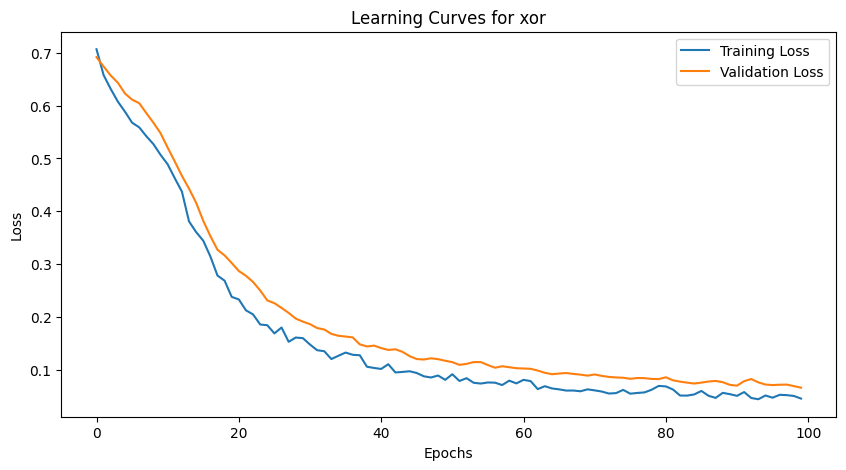


Plotting learning curves for center_surround...


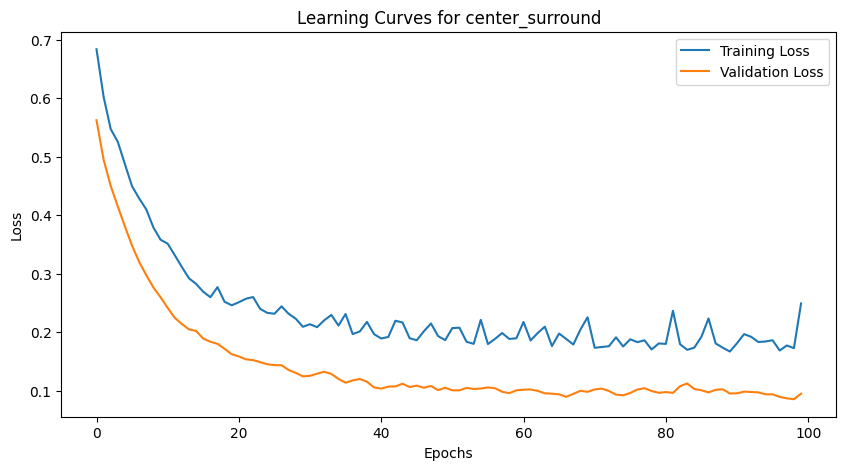


Plotting learning curves for two_gaussians...


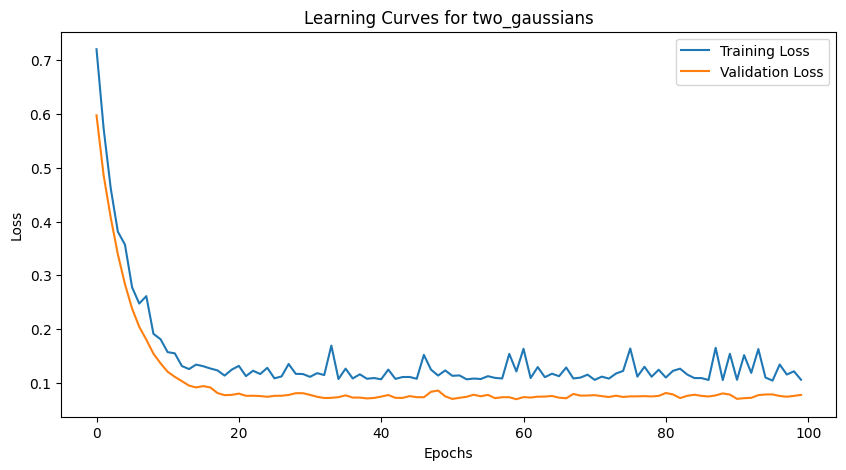


Plotting learning curves for spiral...


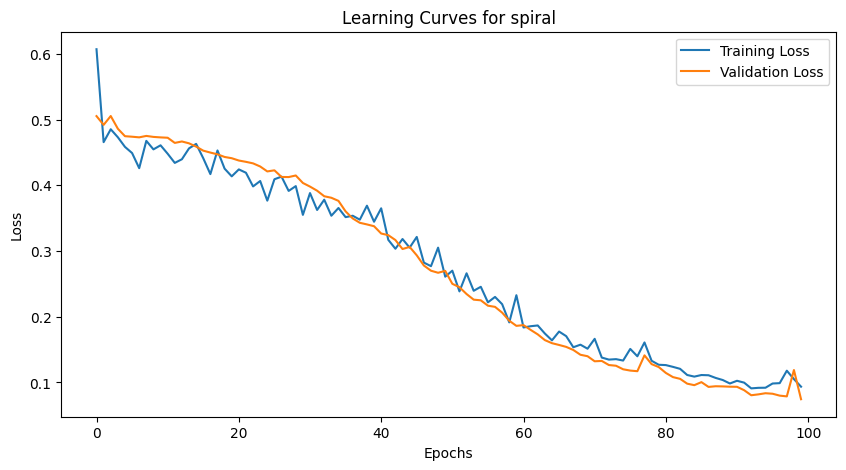

In [8]:
import matplotlib.pyplot as plt

# Plot learning curves for each dataset
for dataset, result in best_results.items():
    print(f"\nPlotting learning curves for {dataset}...")

    # Plot learning curves
    plt.figure(figsize=(10, 5))
    plt.plot(result['train_losses'], label='Training Loss')
    plt.plot(result['val_losses'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Learning Curves for {dataset}')
    plt.legend()
    plt.show()


### c. provide the final text accuracy

In [9]:
# Compute and print test accuracy for each dataset
for dataset, result in best_results.items():
    print(f"\nComputing test accuracy for {dataset}...")

    # Evaluate the model on the test set
    test_loader = DataLoader(CustomDataset(*read_data(dataset, 'test')), batch_size=batch_size, shuffle=False)
    val_accuracy, val_loss = evaluate_model(result['model'], test_loader, nn.CrossEntropyLoss())

    # Print the test accuracy
    print(f"Test Accuracy for {dataset}: {val_accuracy:.2f}\n")


Computing test accuracy for xor...
Test Accuracy for xor: 1.00


Computing test accuracy for center_surround...
Test Accuracy for center_surround: 0.74


Computing test accuracy for two_gaussians...
Test Accuracy for two_gaussians: 0.91


Computing test accuracy for spiral...
Test Accuracy for spiral: 1.00



### d. plot the learned decision surface along with observations from the test set


Plotting decision surface for xor...


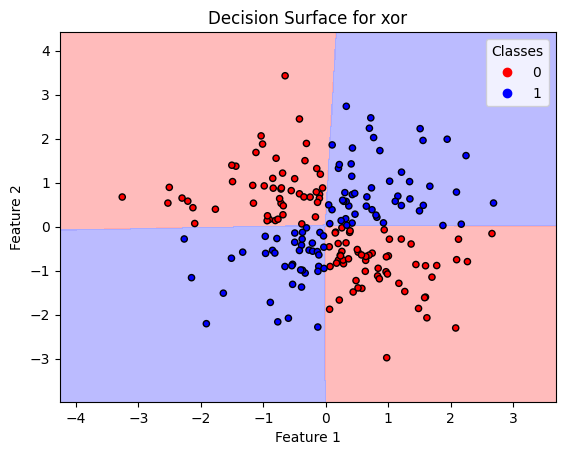


Plotting decision surface for center_surround...


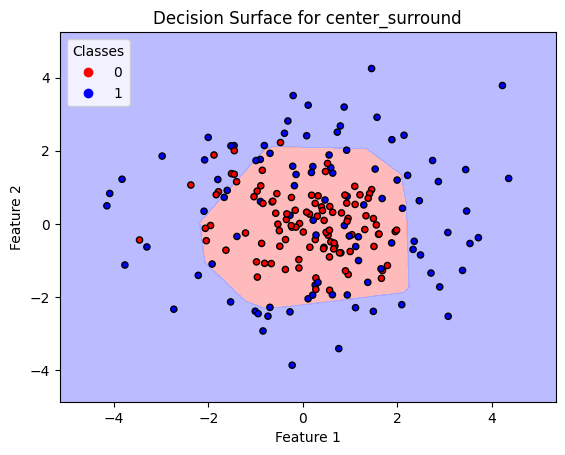


Plotting decision surface for two_gaussians...


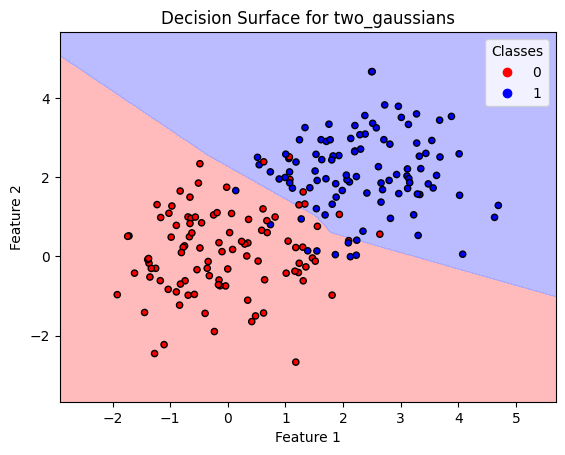


Plotting decision surface for spiral...


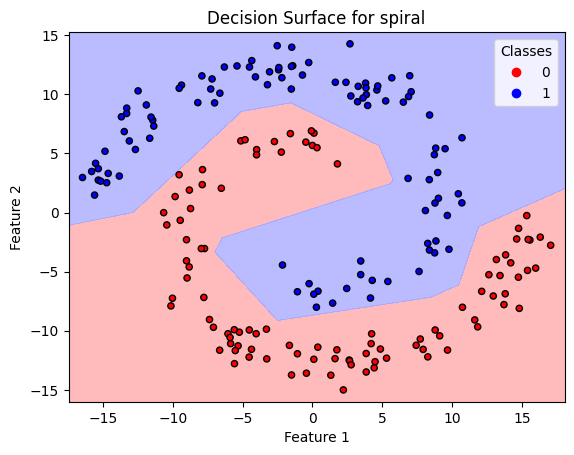

In [10]:
# Plot the decision surface for each dataset
for dataset, result in best_results.items():
    print(f"\nPlotting decision surface for {dataset}...")

    # Get the model and dataset information
    best_model = result['model']
    features_test, labels_test = read_data(dataset, 'test')

    # Plot decision surface
    plot_decision_surface(best_model, np.array(features_test), np.array(labels_test), title=f"Decision Surface for {dataset}")
    plt.show()


## e. discuss your design choices and comment on how they impact performance.

# Part 2

## a. MSE list hyper-parameters used in the model

Learning rate: 0.01

Batch size: 32

Epochs: 100

Best hidden layer size: 7


### Best results for all datasets:
xor: Best k = 9

center_surround: Best k = 7

two_gaussians: Best k = 2

spiral: Best k = 7






In [19]:
# Hyperparameters
k_values = [2, 3, 5, 7, 9]
epochs = 100
learning_rate = 0.01
batch_size = 32

# PyTorch-compatible dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

datasets = ['xor', 'center_surround', 'two_gaussians', 'spiral']
for dataset in datasets:
# dataset = 'xor'
    print(f"Processing {dataset}...")

    # Use the provided read_data function to load the dataset
    features_train, labels_train = read_data(dataset, 'train')  # Assuming the format is `datasetname_train.csv`
    features_valid, labels_valid = read_data(dataset, 'valid')  # Assuming the format is `datasetname_train.csv`
    features_test, labels_test = read_data(dataset, 'test')  # Assuming the format is `datasetname_train.csv`

    print("train_labels",labels_train)

    # Create DataLoaders
    train_dataset = CustomDataset(features_train, labels_train)
    val_dataset = CustomDataset(features_valid, labels_valid)
    test_dataset = CustomDataset(features_test, labels_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_size = 2  # Number of input features
    output_size = 2  # Number of classes
    # Train and find the best k
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.MSELoss()
    best_k, best_model, train_losses, val_losses = train_model(train_loader, val_loader, input_size, output_size, k_values, epochs, learning_rate, criterion)
#     print(f"Best number of nodes for {dataset}: {best_k}\n")
    # Store the results in best_results
    best_results[dataset] = {
        "best_k": best_k,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "model": best_model
    }

    # Print Hyperparameters and Best k for the dataset
    print(f"Best number of nodes for {dataset}: {best_k}")
    print(f"Learning rate: {learning_rate}")
    print(f"Batch size: {batch_size}")
    print(f"Epochs: {epochs}")
    print(f"Best hidden layer size: {best_k}\n")

# At the end of Part a, print all the best_results for the datasets
print("\nBest results for all datasets:")
for dataset, result in best_results.items():
    print(f"{dataset}: Best k = {result['best_k']}")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Processing xor...
train_labels [0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Training with 2 nodes in the hidden layer...
Epoch 1/100, Loss: 3.9113, Validation Accuracy: 0.48
Epoch 

Epoch 85/100, Loss: 1.1852, Validation Accuracy: 0.71
Epoch 86/100, Loss: 1.1715, Validation Accuracy: 0.72
Epoch 87/100, Loss: 1.2158, Validation Accuracy: 0.71
Epoch 88/100, Loss: 1.1974, Validation Accuracy: 0.70
Epoch 89/100, Loss: 1.2039, Validation Accuracy: 0.71
Epoch 90/100, Loss: 1.1939, Validation Accuracy: 0.73
Epoch 91/100, Loss: 1.1941, Validation Accuracy: 0.72
Epoch 92/100, Loss: 1.2217, Validation Accuracy: 0.71
Epoch 93/100, Loss: 1.1246, Validation Accuracy: 0.72
Epoch 94/100, Loss: 1.1760, Validation Accuracy: 0.72
Epoch 95/100, Loss: 1.1445, Validation Accuracy: 0.71
Epoch 96/100, Loss: 1.2163, Validation Accuracy: 0.71
Epoch 97/100, Loss: 1.1571, Validation Accuracy: 0.71
Epoch 98/100, Loss: 1.2066, Validation Accuracy: 0.71
Epoch 99/100, Loss: 1.2012, Validation Accuracy: 0.71
Epoch 100/100, Loss: 1.1672, Validation Accuracy: 0.71
Training with 3 nodes in the hidden layer...
Epoch 1/100, Loss: 6.3203, Validation Accuracy: 0.46
Epoch 2/100, Loss: 5.0478, Validation

Epoch 38/100, Loss: 0.6697, Validation Accuracy: 0.85
Epoch 39/100, Loss: 0.6761, Validation Accuracy: 0.85
Epoch 40/100, Loss: 0.6426, Validation Accuracy: 0.85
Epoch 41/100, Loss: 0.6461, Validation Accuracy: 0.84
Epoch 42/100, Loss: 0.6598, Validation Accuracy: 0.86
Epoch 43/100, Loss: 0.6256, Validation Accuracy: 0.84
Epoch 44/100, Loss: 0.6238, Validation Accuracy: 0.82
Epoch 45/100, Loss: 0.6091, Validation Accuracy: 0.81
Epoch 46/100, Loss: 0.5903, Validation Accuracy: 0.82
Epoch 47/100, Loss: 0.6489, Validation Accuracy: 0.82
Epoch 48/100, Loss: 0.6310, Validation Accuracy: 0.81
Epoch 49/100, Loss: 0.6257, Validation Accuracy: 0.81
Epoch 50/100, Loss: 0.5980, Validation Accuracy: 0.84
Epoch 51/100, Loss: 0.6071, Validation Accuracy: 0.84
Epoch 52/100, Loss: 0.6115, Validation Accuracy: 0.82
Epoch 53/100, Loss: 0.5916, Validation Accuracy: 0.81
Epoch 54/100, Loss: 0.6209, Validation Accuracy: 0.81
Epoch 55/100, Loss: 0.5921, Validation Accuracy: 0.84
Epoch 56/100, Loss: 0.6138, 

Epoch 93/100, Loss: 0.5262, Validation Accuracy: 0.91
Epoch 94/100, Loss: 0.5580, Validation Accuracy: 0.91
Epoch 95/100, Loss: 0.5184, Validation Accuracy: 0.91
Epoch 96/100, Loss: 0.5594, Validation Accuracy: 0.90
Epoch 97/100, Loss: 0.5382, Validation Accuracy: 0.92
Epoch 98/100, Loss: 0.5363, Validation Accuracy: 0.88
Epoch 99/100, Loss: 0.4964, Validation Accuracy: 0.91
Epoch 100/100, Loss: 0.4827, Validation Accuracy: 0.91
Training with 9 nodes in the hidden layer...
Epoch 1/100, Loss: 4.8180, Validation Accuracy: 0.39
Epoch 2/100, Loss: 2.8750, Validation Accuracy: 0.41
Epoch 3/100, Loss: 2.0130, Validation Accuracy: 0.48
Epoch 4/100, Loss: 1.6939, Validation Accuracy: 0.51
Epoch 5/100, Loss: 1.4667, Validation Accuracy: 0.56
Epoch 6/100, Loss: 1.3385, Validation Accuracy: 0.67
Epoch 7/100, Loss: 1.2223, Validation Accuracy: 0.76
Epoch 8/100, Loss: 1.0896, Validation Accuracy: 0.78
Epoch 9/100, Loss: 1.0940, Validation Accuracy: 0.83
Epoch 10/100, Loss: 0.9854, Validation Accura

Epoch 31/100, Loss: 1.7360, Validation Accuracy: 0.65
Epoch 32/100, Loss: 1.7315, Validation Accuracy: 0.65
Epoch 33/100, Loss: 1.7375, Validation Accuracy: 0.65
Epoch 34/100, Loss: 1.7427, Validation Accuracy: 0.65
Epoch 35/100, Loss: 1.7231, Validation Accuracy: 0.66
Epoch 36/100, Loss: 1.7261, Validation Accuracy: 0.66
Epoch 37/100, Loss: 1.7271, Validation Accuracy: 0.47
Epoch 38/100, Loss: 1.7258, Validation Accuracy: 0.47
Epoch 39/100, Loss: 1.7135, Validation Accuracy: 0.47
Epoch 40/100, Loss: 1.7109, Validation Accuracy: 0.67
Epoch 41/100, Loss: 1.7119, Validation Accuracy: 0.67
Epoch 42/100, Loss: 1.6982, Validation Accuracy: 0.66
Epoch 43/100, Loss: 1.6974, Validation Accuracy: 0.66
Epoch 44/100, Loss: 1.6996, Validation Accuracy: 0.67
Epoch 45/100, Loss: 1.6941, Validation Accuracy: 0.66
Epoch 46/100, Loss: 1.6938, Validation Accuracy: 0.67
Epoch 47/100, Loss: 1.6776, Validation Accuracy: 0.67
Epoch 48/100, Loss: 1.6866, Validation Accuracy: 0.67
Epoch 49/100, Loss: 1.6768, 

Epoch 85/100, Loss: 1.1155, Validation Accuracy: 0.84
Epoch 86/100, Loss: 1.1060, Validation Accuracy: 0.85
Epoch 87/100, Loss: 1.1040, Validation Accuracy: 0.85
Epoch 88/100, Loss: 1.0568, Validation Accuracy: 0.82
Epoch 89/100, Loss: 1.1167, Validation Accuracy: 0.84
Epoch 90/100, Loss: 1.0855, Validation Accuracy: 0.84
Epoch 91/100, Loss: 1.1774, Validation Accuracy: 0.84
Epoch 92/100, Loss: 1.1060, Validation Accuracy: 0.84
Epoch 93/100, Loss: 1.0556, Validation Accuracy: 0.83
Epoch 94/100, Loss: 1.0429, Validation Accuracy: 0.84
Epoch 95/100, Loss: 1.0921, Validation Accuracy: 0.84
Epoch 96/100, Loss: 1.0703, Validation Accuracy: 0.84
Epoch 97/100, Loss: 1.1410, Validation Accuracy: 0.84
Epoch 98/100, Loss: 1.0736, Validation Accuracy: 0.83
Epoch 99/100, Loss: 1.0139, Validation Accuracy: 0.84
Epoch 100/100, Loss: 1.0042, Validation Accuracy: 0.84
Training with 5 nodes in the hidden layer...
Epoch 1/100, Loss: 5.4554, Validation Accuracy: 0.77
Epoch 2/100, Loss: 2.9797, Validation

Epoch 39/100, Loss: 0.5680, Validation Accuracy: 0.98
Epoch 40/100, Loss: 0.5877, Validation Accuracy: 0.97
Epoch 41/100, Loss: 0.5890, Validation Accuracy: 0.97
Epoch 42/100, Loss: 0.5799, Validation Accuracy: 0.97
Epoch 43/100, Loss: 0.5566, Validation Accuracy: 0.97
Epoch 44/100, Loss: 0.6113, Validation Accuracy: 0.97
Epoch 45/100, Loss: 0.6439, Validation Accuracy: 0.97
Epoch 46/100, Loss: 0.5804, Validation Accuracy: 0.97
Epoch 47/100, Loss: 0.5676, Validation Accuracy: 0.97
Epoch 48/100, Loss: 0.6172, Validation Accuracy: 0.98
Epoch 49/100, Loss: 0.6562, Validation Accuracy: 0.97
Epoch 50/100, Loss: 0.5971, Validation Accuracy: 0.97
Epoch 51/100, Loss: 0.5754, Validation Accuracy: 0.97
Epoch 52/100, Loss: 0.5700, Validation Accuracy: 0.98
Epoch 53/100, Loss: 0.6055, Validation Accuracy: 0.97
Epoch 54/100, Loss: 0.5761, Validation Accuracy: 0.97
Epoch 55/100, Loss: 0.6036, Validation Accuracy: 0.97
Epoch 56/100, Loss: 0.6171, Validation Accuracy: 0.97
Epoch 57/100, Loss: 0.5362, 

Epoch 99/100, Loss: 0.5896, Validation Accuracy: 0.97
Epoch 100/100, Loss: 0.5299, Validation Accuracy: 0.97
Best number of nodes: 7, Best Validation Accuracy: 0.98
Best number of nodes for center_surround: 7
Learning rate: 0.01
Batch size: 32
Epochs: 100
Best hidden layer size: 7

Processing two_gaussians...
train_labels [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0]
Training with 2 nodes in the hidden layer...
Epoch 1/100, Loss: 6.6790, Val

Epoch 43/100, Loss: 0.3565, Validation Accuracy: 0.98
Epoch 44/100, Loss: 0.3452, Validation Accuracy: 0.98
Epoch 45/100, Loss: 0.3651, Validation Accuracy: 0.98
Epoch 46/100, Loss: 0.3688, Validation Accuracy: 0.98
Epoch 47/100, Loss: 0.4078, Validation Accuracy: 0.98
Epoch 48/100, Loss: 0.3524, Validation Accuracy: 0.98
Epoch 49/100, Loss: 0.3632, Validation Accuracy: 0.98
Epoch 50/100, Loss: 0.3876, Validation Accuracy: 0.98
Epoch 51/100, Loss: 0.3839, Validation Accuracy: 0.97
Epoch 52/100, Loss: 0.3413, Validation Accuracy: 0.98
Epoch 53/100, Loss: 0.3542, Validation Accuracy: 0.98
Epoch 54/100, Loss: 0.4482, Validation Accuracy: 0.98
Epoch 55/100, Loss: 0.3682, Validation Accuracy: 0.98
Epoch 56/100, Loss: 0.4123, Validation Accuracy: 0.98
Epoch 57/100, Loss: 0.4279, Validation Accuracy: 0.98
Epoch 58/100, Loss: 0.3751, Validation Accuracy: 0.98
Epoch 59/100, Loss: 0.3427, Validation Accuracy: 0.98
Epoch 60/100, Loss: 0.4557, Validation Accuracy: 0.98
Epoch 61/100, Loss: 0.3556, 

Epoch 2/100, Loss: 2.5996, Validation Accuracy: 0.53
Epoch 3/100, Loss: 2.0148, Validation Accuracy: 0.60
Epoch 4/100, Loss: 1.6037, Validation Accuracy: 0.74
Epoch 5/100, Loss: 1.2190, Validation Accuracy: 0.79
Epoch 6/100, Loss: 0.9047, Validation Accuracy: 0.86
Epoch 7/100, Loss: 0.8303, Validation Accuracy: 0.91
Epoch 8/100, Loss: 0.6384, Validation Accuracy: 0.94
Epoch 9/100, Loss: 0.5972, Validation Accuracy: 0.94
Epoch 10/100, Loss: 0.5253, Validation Accuracy: 0.96
Epoch 11/100, Loss: 0.5343, Validation Accuracy: 0.97
Epoch 12/100, Loss: 0.4337, Validation Accuracy: 0.96
Epoch 13/100, Loss: 0.4501, Validation Accuracy: 0.97
Epoch 14/100, Loss: 0.4045, Validation Accuracy: 0.97
Epoch 15/100, Loss: 0.4233, Validation Accuracy: 0.97
Epoch 16/100, Loss: 0.3750, Validation Accuracy: 0.97
Epoch 17/100, Loss: 0.4356, Validation Accuracy: 0.97
Epoch 18/100, Loss: 0.4763, Validation Accuracy: 0.98
Epoch 19/100, Loss: 0.3694, Validation Accuracy: 0.97
Epoch 20/100, Loss: 0.3675, Validati

Epoch 62/100, Loss: 0.2722, Validation Accuracy: 0.98
Epoch 63/100, Loss: 0.2383, Validation Accuracy: 0.98
Epoch 64/100, Loss: 0.2354, Validation Accuracy: 0.98
Epoch 65/100, Loss: 0.2331, Validation Accuracy: 0.98
Epoch 66/100, Loss: 0.2753, Validation Accuracy: 0.98
Epoch 67/100, Loss: 0.3070, Validation Accuracy: 0.98
Epoch 68/100, Loss: 0.2636, Validation Accuracy: 0.98
Epoch 69/100, Loss: 0.2296, Validation Accuracy: 0.98
Epoch 70/100, Loss: 0.2473, Validation Accuracy: 0.98
Epoch 71/100, Loss: 0.2641, Validation Accuracy: 0.98
Epoch 72/100, Loss: 0.3249, Validation Accuracy: 0.97
Epoch 73/100, Loss: 0.2313, Validation Accuracy: 0.98
Epoch 74/100, Loss: 0.2939, Validation Accuracy: 0.98
Epoch 75/100, Loss: 0.2748, Validation Accuracy: 0.98
Epoch 76/100, Loss: 0.2302, Validation Accuracy: 0.98
Epoch 77/100, Loss: 0.2288, Validation Accuracy: 0.97
Epoch 78/100, Loss: 0.2283, Validation Accuracy: 0.98
Epoch 79/100, Loss: 0.2304, Validation Accuracy: 0.98
Epoch 80/100, Loss: 0.2640, 

Epoch 4/100, Loss: 1.9408, Validation Accuracy: 0.72
Epoch 5/100, Loss: 1.9017, Validation Accuracy: 0.69
Epoch 6/100, Loss: 1.7582, Validation Accuracy: 0.77
Epoch 7/100, Loss: 1.5311, Validation Accuracy: 0.76
Epoch 8/100, Loss: 1.4598, Validation Accuracy: 0.76
Epoch 9/100, Loss: 1.3894, Validation Accuracy: 0.74
Epoch 10/100, Loss: 1.3186, Validation Accuracy: 0.77
Epoch 11/100, Loss: 1.3407, Validation Accuracy: 0.76
Epoch 12/100, Loss: 1.2154, Validation Accuracy: 0.77
Epoch 13/100, Loss: 1.2201, Validation Accuracy: 0.74
Epoch 14/100, Loss: 1.1779, Validation Accuracy: 0.75
Epoch 15/100, Loss: 1.1389, Validation Accuracy: 0.76
Epoch 16/100, Loss: 1.1335, Validation Accuracy: 0.76
Epoch 17/100, Loss: 1.1530, Validation Accuracy: 0.77
Epoch 18/100, Loss: 1.0821, Validation Accuracy: 0.76
Epoch 19/100, Loss: 1.1117, Validation Accuracy: 0.74
Epoch 20/100, Loss: 1.0704, Validation Accuracy: 0.77
Epoch 21/100, Loss: 1.0792, Validation Accuracy: 0.76
Epoch 22/100, Loss: 1.1228, Valida

Epoch 63/100, Loss: 1.0235, Validation Accuracy: 0.71
Epoch 64/100, Loss: 1.0782, Validation Accuracy: 0.71
Epoch 65/100, Loss: 1.0277, Validation Accuracy: 0.71
Epoch 66/100, Loss: 1.0389, Validation Accuracy: 0.70
Epoch 67/100, Loss: 1.0261, Validation Accuracy: 0.70
Epoch 68/100, Loss: 1.0937, Validation Accuracy: 0.71
Epoch 69/100, Loss: 1.0500, Validation Accuracy: 0.72
Epoch 70/100, Loss: 1.0366, Validation Accuracy: 0.70
Epoch 71/100, Loss: 1.0516, Validation Accuracy: 0.71
Epoch 72/100, Loss: 1.0696, Validation Accuracy: 0.71
Epoch 73/100, Loss: 0.9337, Validation Accuracy: 0.71
Epoch 74/100, Loss: 0.9445, Validation Accuracy: 0.72
Epoch 75/100, Loss: 0.9648, Validation Accuracy: 0.71
Epoch 76/100, Loss: 1.0316, Validation Accuracy: 0.71
Epoch 77/100, Loss: 0.9920, Validation Accuracy: 0.71
Epoch 78/100, Loss: 1.0080, Validation Accuracy: 0.72
Epoch 79/100, Loss: 1.0030, Validation Accuracy: 0.72
Epoch 80/100, Loss: 0.9797, Validation Accuracy: 0.72
Epoch 81/100, Loss: 0.9679, 

Epoch 17/100, Loss: 1.0945, Validation Accuracy: 0.72
Epoch 18/100, Loss: 1.1951, Validation Accuracy: 0.76
Epoch 19/100, Loss: 1.0661, Validation Accuracy: 0.76
Epoch 20/100, Loss: 1.1191, Validation Accuracy: 0.76
Epoch 21/100, Loss: 1.1515, Validation Accuracy: 0.73
Epoch 22/100, Loss: 1.1086, Validation Accuracy: 0.71
Epoch 23/100, Loss: 1.0311, Validation Accuracy: 0.71
Epoch 24/100, Loss: 1.1066, Validation Accuracy: 0.71
Epoch 25/100, Loss: 1.1093, Validation Accuracy: 0.71
Epoch 26/100, Loss: 1.0886, Validation Accuracy: 0.76
Epoch 27/100, Loss: 1.0070, Validation Accuracy: 0.71
Epoch 28/100, Loss: 1.0899, Validation Accuracy: 0.71
Epoch 29/100, Loss: 1.0366, Validation Accuracy: 0.74
Epoch 30/100, Loss: 1.0273, Validation Accuracy: 0.74
Epoch 31/100, Loss: 1.0232, Validation Accuracy: 0.72
Epoch 32/100, Loss: 1.0028, Validation Accuracy: 0.75
Epoch 33/100, Loss: 1.0876, Validation Accuracy: 0.71
Epoch 34/100, Loss: 1.0242, Validation Accuracy: 0.71
Epoch 35/100, Loss: 1.1508, 

In [23]:
print(best_results)

{'xor': {'best_k': 9, 'train_losses': [0.6882910558155605, 0.41070905327796936, 0.28757085118974957, 0.24197995449815476, 0.20953491755894252, 0.1912211094583784, 0.17461508299623216, 0.15565850266388484, 0.15628539770841599, 0.1407673486641475, 0.13323091502700532, 0.12463755267007011, 0.11832830629178456, 0.12088924220630101, 0.11751714135919299, 0.11401668616703578, 0.11699759215116501, 0.10962352050202233, 0.11427606216498784, 0.1011931768485478, 0.09962430277041026, 0.10223981631653649, 0.10747547873428889, 0.09765195474028587, 0.10813093717609133, 0.09845593358789172, 0.10049577802419662, 0.09722252296549934, 0.0915975102356502, 0.09914283667291914, 0.08947010870490756, 0.09503968272890363, 0.0884905116898673, 0.09713966718741826, 0.08739826934678215, 0.0901839914066451, 0.08523398957082204, 0.09189396245138985, 0.09709841012954712, 0.09048348026616233, 0.08876137541873115, 0.08759395033121109, 0.09065380798918861, 0.09228440054825374, 0.08050396027309555, 0.092729780290808, 0.08

### b. plot the learning curves for training and validation loss as a function of training epochs


Plotting learning curves for xor...


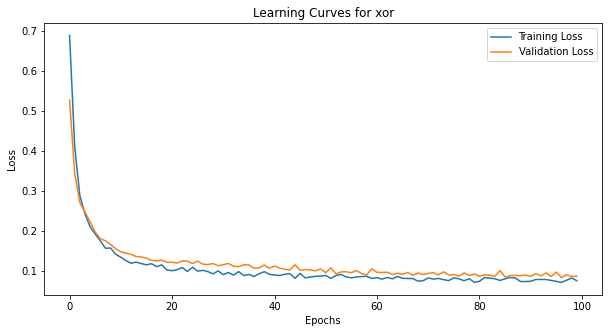


Plotting learning curves for center_surround...


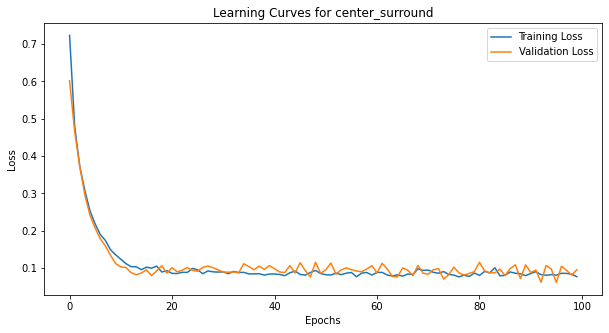


Plotting learning curves for two_gaussians...


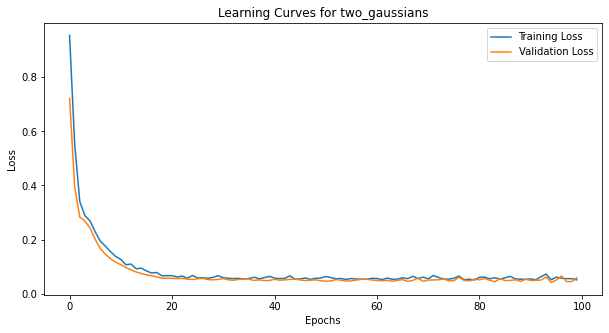


Plotting learning curves for spiral...


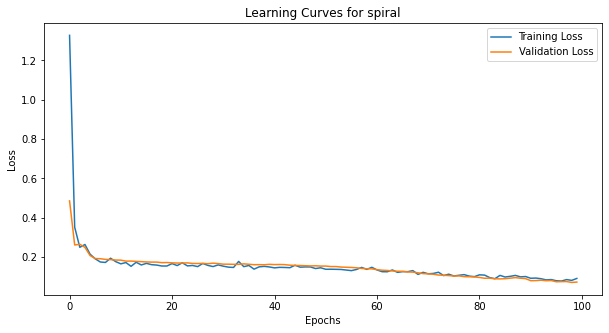

In [20]:
import matplotlib.pyplot as plt

# Plot learning curves for each dataset
for dataset, result in best_results.items():
    print(f"\nPlotting learning curves for {dataset}...")

    # Plot learning curves
    plt.figure(figsize=(10, 5))
    plt.plot(result['train_losses'], label='Training Loss')
    plt.plot(result['val_losses'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Learning Curves for {dataset}')
    plt.legend()
    plt.show()


### c. provide the final text accuracy

In [21]:
# Compute and print test accuracy for each dataset
for dataset, result in best_results.items():
    print(f"\nComputing test accuracy for {dataset}...")

    # Evaluate the model on the test set
    test_loader = DataLoader(CustomDataset(*read_data(dataset, 'test')), batch_size=batch_size, shuffle=False)
    val_accuracy, val_loss = evaluate_model(result['model'], test_loader, nn.CrossEntropyLoss())

    # Print the test accuracy
    print(f"Test Accuracy for {dataset}: {val_accuracy:.2f}\n")



Computing test accuracy for xor...
Test Accuracy for xor: 0.93


Computing test accuracy for center_surround...
Test Accuracy for center_surround: 0.75


Computing test accuracy for two_gaussians...
Test Accuracy for two_gaussians: 0.92


Computing test accuracy for spiral...
Test Accuracy for spiral: 0.94



### d. plot the learned decision surface along with observations from the test set


Plotting decision surface for xor...


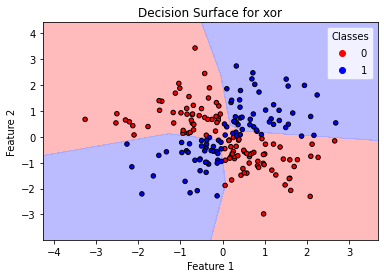


Plotting decision surface for center_surround...


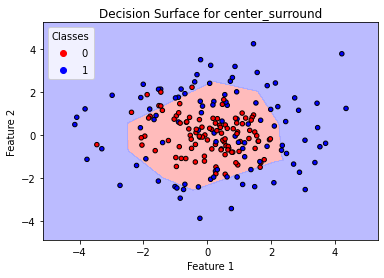


Plotting decision surface for two_gaussians...


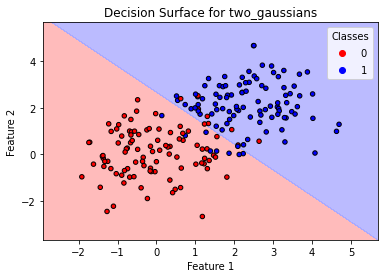


Plotting decision surface for spiral...


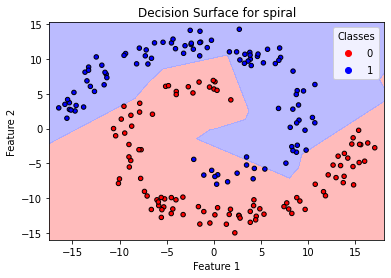

In [22]:
# Plot the decision surface for each dataset
for dataset, result in best_results.items():
    print(f"\nPlotting decision surface for {dataset}...")

    # Get the model and dataset information
    best_model = result['model']
    features_test, labels_test = read_data(dataset, 'test')

    # Plot decision surface
    plot_decision_surface(best_model, np.array(features_test), np.array(labels_test), title=f"Decision Surface for {dataset}")
    plt.show()


### e. discuss your design choices and comment on how they impact performance.

## 3. Manual Gradients and Updates

In [ ]:
import numpy as np


def read_data(name,mode):
    features = []
    labels = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root,name,mode)

    i = 0
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                features.append([x1,x2])
                labels.append(y)
            i = i + 1
    # return (np.array(features,dtype='float32'), np.array(labels,dtype='long'))
    return features, labels

features_train, labels_train = read_data(dataset, 'train')  # Assuming the format is `datasetname_train.csv`
features_valid, labels_valid = read_data(dataset, 'valid')  # Assuming the format is `datasetname_train.csv`
features_test, labels_test = read_data(dataset, 'test')  # Assuming the format is `datasetname_train.csv`

# 1. Define the dataset
# np.random.seed(42)
# X = np.random.rand(100, 2)  # 100 samples, 2 features
# y = (np.sum(X, axis=1) > 1).astype(float).reshape(-1, 1)  # Binary target (1 if sum > 1, else 0)

# 2. Initialize weights and biases
input_size = 2
hidden_size = 3
output_size = 2

W1 = np.random.randn(input_size, hidden_size) * 0.01  # Input to hidden weights
b1 = np.zeros((1, hidden_size))  # Hidden layer biases
W2 = np.random.randn(hidden_size, output_size) * 0.01  # Hidden to output weights
b2 = np.zeros((1, output_size))  # Output layer biases

# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# 3. Forward pass
def forward(X):
    Z1 = np.dot(X, W1) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)
    return Z1, A1, Z2, A2

# 4. Loss function (Binary Cross-Entropy)
def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / m
    return loss

# 5. Backward pass
def backward(X, y, Z1, A1, Z2, A2):
    m = y.shape[0]

    # Output layer gradients
    dA2 = -(y / A2 - (1 - y) / (1 - A2))  # Derivative of loss wrt A2
    dZ2 = dA2 * sigmoid_derivative(Z2)  # Derivative of A2 wrt Z2
    dW2 = np.dot(A1.T, dZ2) / m         # Derivative of Z2 wrt W2
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m  # Derivative of Z2 wrt b2

    # Hidden layer gradients
    dA1 = np.dot(dZ2, W2.T)             # Derivative of Z2 wrt A1
    dZ1 = dA1 * sigmoid_derivative(Z1)  # Derivative of A1 wrt Z1
    dW1 = np.dot(X.T, dZ1) / m          # Derivative of Z1 wrt W1
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m  # Derivative of Z1 wrt b1

    return dW1, db1, dW2, db2

# 6. Update parameters
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr=0.01):
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2
    return W1, b1, W2, b2

# Training loop
epochs = 100
learning_rate = 0.01

for epoch in range(epochs):
    # Forward pass
    Z1, A1, Z2, A2 = forward(features_train)

    # Compute loss
    loss = compute_loss(np.array(labels_train), A2)

    # Backward pass
    dW1, db1, dW2, db2 = backward(np.array(features_train), np.array(labels_train), Z1, A1, Z2, A2)

    # Update parameters
    W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr=learning_rate)

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Verify with predictions
Z1, A1, Z2, A2 = forward(features_test)
predictions = (A2 > 0.5).astype(float)
accuracy = np.mean(predictions == labels_test)
print(f"Training Accuracy: {accuracy:.2f}")

## 4. regularizers

Processing xor...
Processing xor unregularized model
Epoch 10/1000, Loss: 3.4548, Validation Accuracy: 0.47
Epoch 20/1000, Loss: 2.6747, Validation Accuracy: 0.50
Epoch 30/1000, Loss: 2.2668, Validation Accuracy: 0.49
Epoch 40/1000, Loss: 1.9812, Validation Accuracy: 0.50
Epoch 50/1000, Loss: 1.8880, Validation Accuracy: 0.51
Epoch 60/1000, Loss: 1.7692, Validation Accuracy: 0.55
Epoch 70/1000, Loss: 1.6762, Validation Accuracy: 0.57
Epoch 80/1000, Loss: 1.6103, Validation Accuracy: 0.56
Epoch 90/1000, Loss: 1.5849, Validation Accuracy: 0.59
Epoch 100/1000, Loss: 1.5851, Validation Accuracy: 0.60
Epoch 110/1000, Loss: 1.5852, Validation Accuracy: 0.61
Epoch 120/1000, Loss: 1.5216, Validation Accuracy: 0.61
Epoch 130/1000, Loss: 1.5981, Validation Accuracy: 0.62
Epoch 140/1000, Loss: 1.5324, Validation Accuracy: 0.62
Epoch 150/1000, Loss: 1.5275, Validation Accuracy: 0.62
Epoch 160/1000, Loss: 1.5404, Validation Accuracy: 0.61
Epoch 170/1000, Loss: 1.5539, Validation Accuracy: 0.62
Epoc

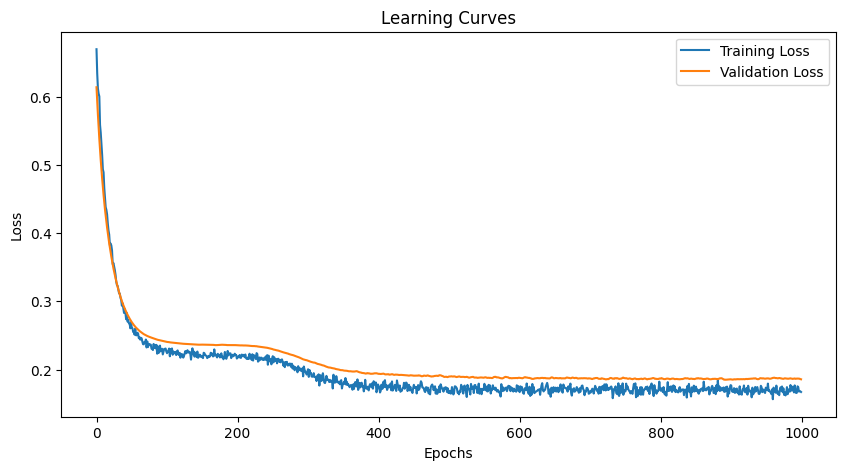

Processing xor regularized model
Epoch 10/1000, Loss: 3.5031, Validation Accuracy: 0.53
Epoch 20/1000, Loss: 2.8024, Validation Accuracy: 0.54
Epoch 30/1000, Loss: 2.3883, Validation Accuracy: 0.55
Epoch 40/1000, Loss: 2.1425, Validation Accuracy: 0.59
Epoch 50/1000, Loss: 2.0238, Validation Accuracy: 0.54
Epoch 60/1000, Loss: 1.9499, Validation Accuracy: 0.46
Epoch 70/1000, Loss: 1.9172, Validation Accuracy: 0.41
Epoch 80/1000, Loss: 1.8728, Validation Accuracy: 0.48
Epoch 90/1000, Loss: 1.8834, Validation Accuracy: 0.52
Epoch 100/1000, Loss: 1.7870, Validation Accuracy: 0.60
Epoch 110/1000, Loss: 1.7251, Validation Accuracy: 0.60
Epoch 120/1000, Loss: 1.7479, Validation Accuracy: 0.66
Epoch 130/1000, Loss: 1.6519, Validation Accuracy: 0.66
Epoch 140/1000, Loss: 1.6058, Validation Accuracy: 0.67
Epoch 150/1000, Loss: 1.5885, Validation Accuracy: 0.66
Epoch 160/1000, Loss: 1.5900, Validation Accuracy: 0.66
Epoch 170/1000, Loss: 1.5043, Validation Accuracy: 0.67
Epoch 180/1000, Loss: 1.

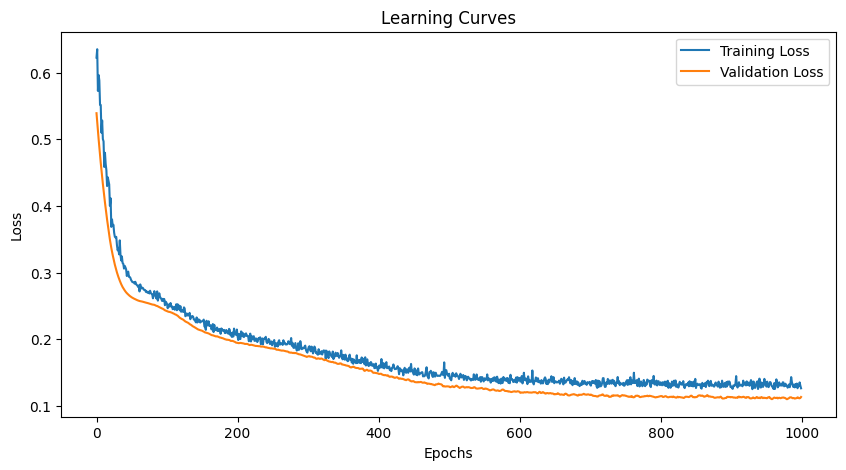

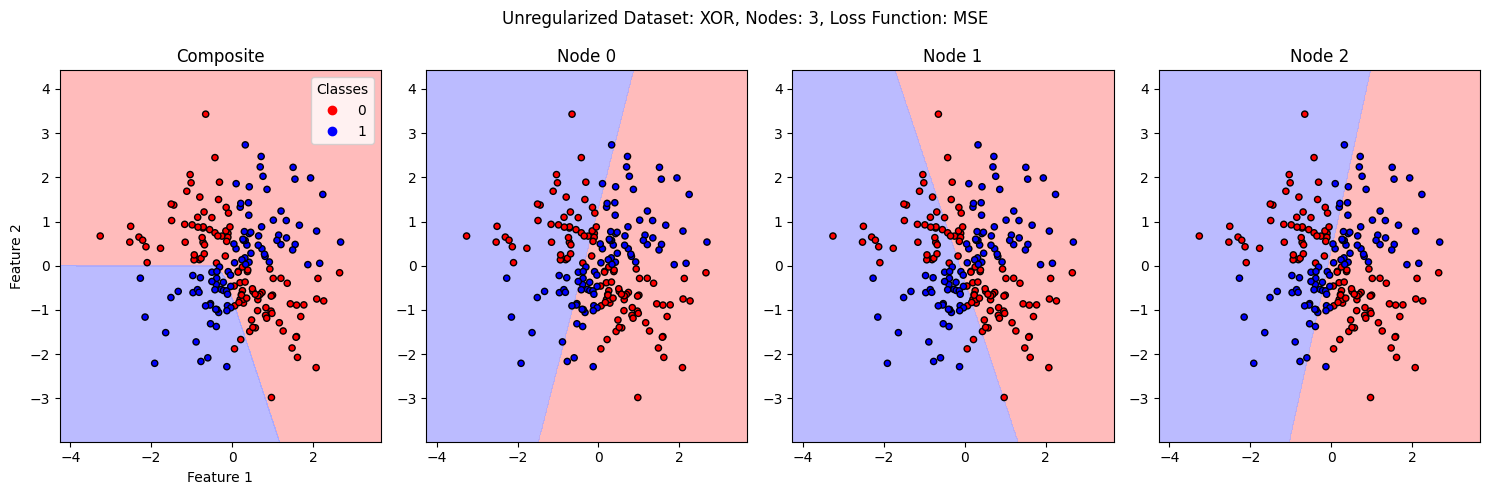

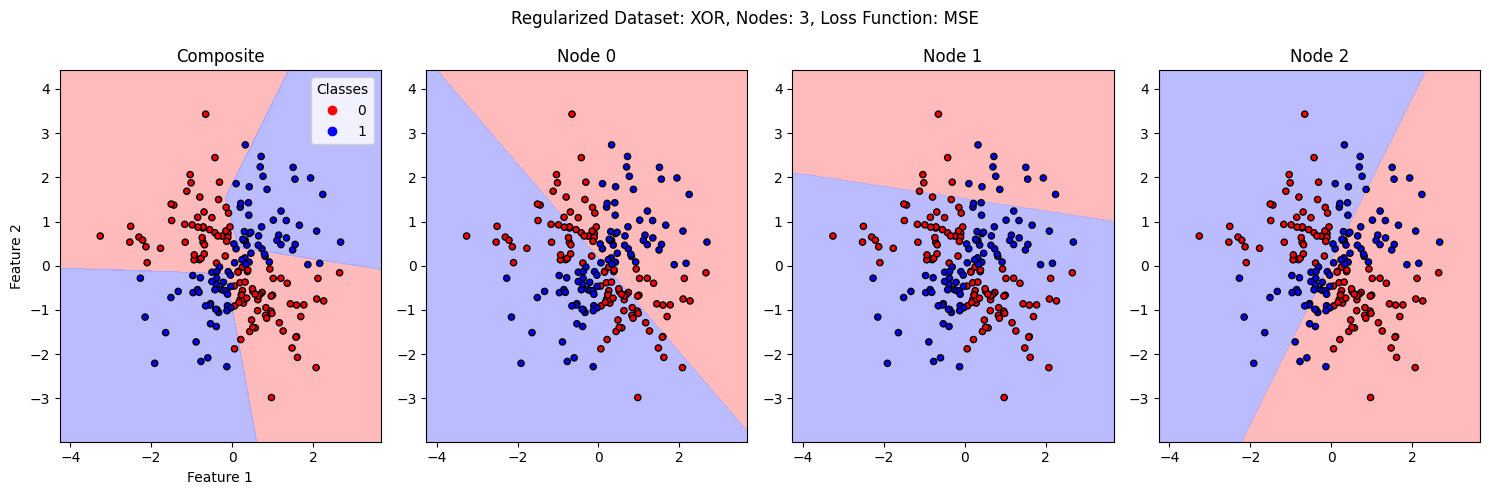

In [20]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

%matplotlib inline

np.random.seed(42)
torch.manual_seed(0)

def read_data(name, mode):
    features = []
    labels = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root, name, mode)

    i = 0
    with open(filename, 'rt') as f:
        for line in f:
            line = line.replace('\n', '')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                features.append([x1, x2])
                labels.append(y)
            i = i + 1
    return features, labels

# Define the FFNN with one hidden layer
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x, return_hidden=False):
        hidden_out = self.hidden(x)
        hidden_activated = self.relu(hidden_out)
        output = self.output(hidden_activated)
        if return_hidden:
            return output, hidden_activated
        return output

def evaluate_model(model, val_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for features, labels in val_loader:
            outputs = model(features)
            if isinstance(criterion, nn.MSELoss):
                labels_one_hot = F.one_hot(labels, num_classes=output_size).float()
                loss = criterion(outputs, labels_one_hot)
            else:
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy, val_loss

def train_model_with_regularizers(train_loader, val_loader, input_size, output_size, hidden_size=3, epochs=100, lr=0.01, criterion=nn.MSELoss(), l1_lambda=0.01, orth_lambda=0.01):
    model = FFNN(input_size, hidden_size, output_size)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=0)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)

            # Compute the primary loss (e.g., MSELoss)
            labels_one_hot = F.one_hot(labels, num_classes=output_size).float()
            loss = criterion(outputs, labels_one_hot)

            # Add L2-norm regularization on input layer weights
            input_weights = model.hidden.weight
            norm_penalty = l1_lambda * torch.norm(input_weights, p=1)
            loss += norm_penalty

            # Add orthogonality regularization for hidden layer weights
            hidden_weights = model.hidden.weight
            identity = torch.eye(hidden_weights.size(1), device=hidden_weights.device)
            orth_penalty = orth_lambda * torch.norm(hidden_weights.T @ hidden_weights - identity, p=1)
            loss += orth_penalty

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Validate the model
        val_accuracy, val_loss = evaluate_model(model, val_loader, criterion)
        train_losses.append(epoch_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}")

    return model, train_losses, val_losses

def plot_decision_surface(model, X, y, ax=None, title="Decision Surface"):
    if ax is None:
        ax = plt.gca()
    
    # Define the grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Predict on the grid
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    Z = model(grid)
    Z = torch.argmax(Z, axis=1).numpy()
    Z = Z.reshape(xx.shape)
    
    # Plot the decision surface
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=cmap_light)
    
    # Plot the training points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    
    # Add labels and title
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)
    ax.legend(*scatter.legend_elements(), title="Classes")

# Hyperparameters
hidden_size = 3
epochs = 1000
learning_rate = 0.001
batch_size = 32
l1_lambda = 0.1
orth_lambda = 0.1

# PyTorch-compatible dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Load the XOR dataset
dataset = 'xor'
print(f"Processing {dataset}...")

features_train, labels_train = read_data(dataset, 'train')
features_valid, labels_valid = read_data(dataset, 'valid')
features_test, labels_test = read_data(dataset, 'test')

train_dataset = CustomDataset(features_train, labels_train)
val_dataset = CustomDataset(features_valid, labels_valid)
test_dataset = CustomDataset(features_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = 2  # Number of input features
output_size = 2  # Number of classes


def plot_hidden_node_boundaries(model, X, y, title="Hidden Node Boundaries", regularized=True):
    fig, axes = plt.subplots(1, hidden_size + 1, figsize=(15, 5))
    if regularized:
        fig.suptitle(f"Regularized Dataset: XOR, Nodes: {hidden_size}, Loss Function: MSE", fontsize=12)
    else:
        fig.suptitle(f"Unregularized Dataset: XOR, Nodes: {hidden_size}, Loss Function: MSE", fontsize=12)

    # Define the grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Composite Decision Boundary
    plot_decision_surface(model, X, y, ax=axes[0], title="Composite")
    
    # Individual Node Boundaries
    for i in range(hidden_size):
        ax = axes[i + 1]
        with torch.no_grad():
            grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
            _, hidden_activated = model(grid, return_hidden=True)
            Z = (hidden_activated[:, i] > 0).numpy()  # Threshold at 0 (ReLU activation)
            Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
        scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']), edgecolor='k', s=20)
        ax.set_title(f"Node {i}")
    plt.tight_layout()
    plt.show()



print("Processing xor unregularized model")
# Train the unregularized model
unregularized_model, unregularized_train_losses, unregularized_val_losses = train_model_with_regularizers(
    train_loader, val_loader, input_size, output_size, hidden_size, epochs, learning_rate, nn.MSELoss(), 0.0, 0.0
)

# Plot learning curves
plt.figure(figsize=(10, 5))
plt.plot(unregularized_train_losses, label='Training Loss')
plt.plot(unregularized_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

print("Processing xor regularized model")
# Train the regularized model
regularized_model, regularized_train_losses, regularized_val_losses= train_model_with_regularizers(
    train_loader, val_loader, input_size, output_size, hidden_size, epochs, learning_rate, nn.MSELoss(), 0.01, 0.01
)

# Plot learning curves
plt.figure(figsize=(10, 5))
plt.plot(regularized_train_losses, label='Training Loss')
plt.plot(regularized_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Plot decision boundaries
plot_hidden_node_boundaries(unregularized_model, np.array(features_test), np.array(labels_test), regularized=False)
plot_hidden_node_boundaries(regularized_model, np.array(features_test), np.array(labels_test), regularized=True)
